## E- Coverage tests

Authors: Noemi Anau Montel, James Alvey, Christoph Weniger

Last update: 15 September 2023

**Purpose**: Testing posteriors and inference results.

**Key take-away messages**: How can we generate pp and zz plot with swyft?

### Code

In [1]:
import numpy as np
import pylab as plt
import torch
import swyft
DEVICE = 'gpu' if torch.cuda.is_available() else 'cpu'

In [2]:
torch.manual_seed(0)
np.random.seed(0)

We again consider the same linear regression problem as above...

In [3]:
N = 10_000  # Number of samples
Nbins = 100
z = np.random.rand(N, 3)*2 - 1
y = np.linspace(-1, 1, Nbins)
m = np.ones_like(y)*z[:,:1] + y*z[:,1:2] + y**2*z[:,2:]
x = m + np.random.randn(N, Nbins)*0.2 #+ np.random.poisson(lam = 3/Nbins, size = (N, Nbins))*5

# We keep the first sample as observation, and use the rest for training
samples = swyft.Samples(x = x, z = z)
obs = swyft.Sample(samples[0])

...as well as an inference network with linear data summaries, ...

In [4]:
class Network(swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        self.summarizer = torch.nn.Linear(Nbins, 3)
        self.logratios = swyft.LogRatioEstimator_1dim(num_features = 1, num_params = 3, varnames = 'z')

    def forward(self, A, B):
        s = self.summarizer(A['x'])
        s = s.unsqueeze(-1)
        return self.logratios(s, B['z'])

...and train our inference network as usual.

In [5]:
trainer = swyft.SwyftTrainer(accelerator = DEVICE, precision = 64)
dm = swyft.SwyftDataModule(samples[1:-500])
network = Network()
trainer.fit(network, dm)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/cweniger/opt/anaconda3/envs/native2/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:200: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Users/cweniger/opt/anaconda3/envs/native2/lib/python3.9/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint

  | Name       | Type                   | Params
------------------------------------------------------
0 | summarizer | Linear                 | 303   
1 | logratios  | LogRatioEstimator_1dim | 52.

Sanity Checking: 0it [00:00, ?it/s]

/Users/cweniger/opt/anaconda3/envs/native2/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/cweniger/opt/anaconda3/envs/native2/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Reloading best model: /Users/cweniger/Documents/swyft/notebooks/lightning_logs/version_20/checkpoints/epoch=7-step=1904.ckpt


Like above, let's look at the posteriors for a specific mock observation `obs`.

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting: 238it [00:00, ?it/s]

/Users/cweniger/opt/anaconda3/envs/native2/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:173: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


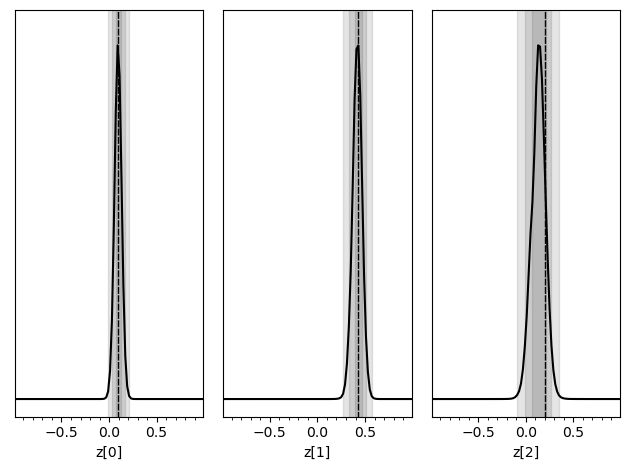

In [6]:
prior_samples = swyft.Samples(z = np.random.rand(10_000, 3)*2-1)
predictions = trainer.infer(network, obs, prior_samples)

truth = {k: v for k, v in zip(["z[%i]"%i for i in range(3)], obs['z'])}
swyft.plot_posterior(predictions, ["z[%i]"%i for i in range(3)], truth=truth)

How do we know that these posteriors are "correct"?  Let us now consider Bayesian coverage.  To this end, we use the last 500 samples and estimate the Bayesian coverage (the fraction of samples where the $1-\alpha$ credible region contains the true value -- which should be $1-\alpha$).

In [7]:
coverage_samples = trainer.test_coverage(network, samples[-500:], prior_samples)

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting: 238it [00:00, ?it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting: 238it [00:00, ?it/s]

The coverage test restults can be visualized using `swyft.plot_pp`, which generates the standard pp-plot commonly seen in the literature. The disadvantage of this plot is that it squashes the particularly interesting high-credibility regions together.

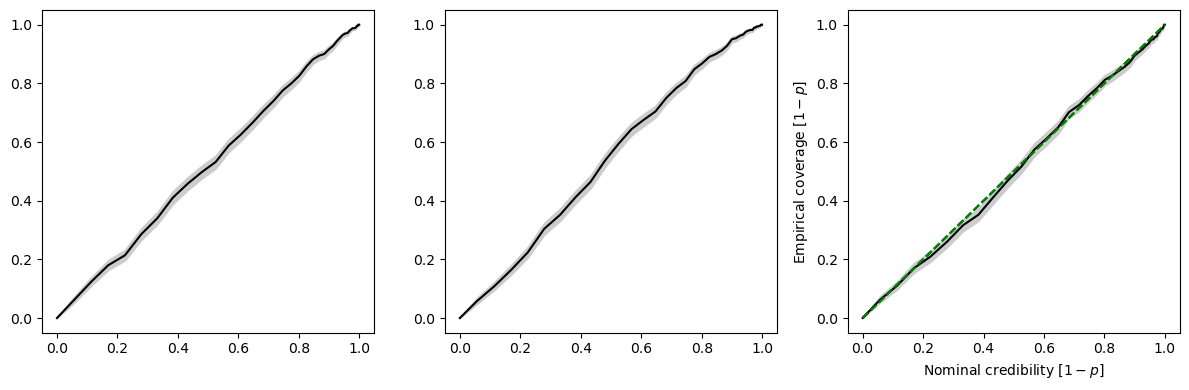

In [8]:
fix, axes = plt.subplots(1, 3, figsize = (12, 4))
for i in range(3):
    swyft.plot_pp(coverage_samples, "z[%i]"%i, ax = axes[i])
plt.tight_layout()

Instead, in Swyft we use something we decided to call zz-plots, `swyft.plot_zz`, which emphasises high credibility regions and visualizes the uncertainties of the coverage test which are associated with a finite sample size (in this example just 500).

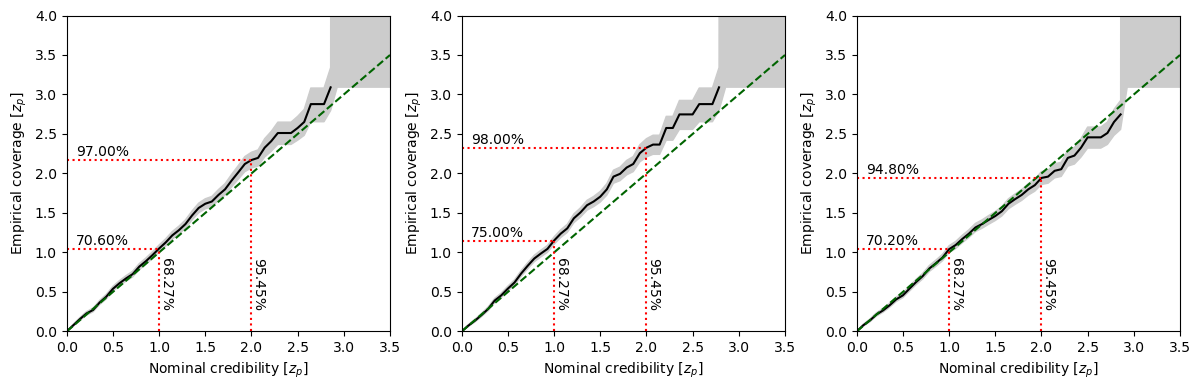

In [9]:
fix, axes = plt.subplots(1, 3, figsize = (12, 4))
for i in range(3):
    swyft.plot_zz(coverage_samples, "z[%i]"%i, ax = axes[i])
plt.tight_layout()

### Exercises

1. Check how coverage changes when reducing or increasing the number of epochs during training.  An overtrained network will have overconfident coverage.

In [10]:
# Your results here